In [2]:
from google.colab import drive
drive.mount('/content/drive/')



Mounted at /content/drive/


In [3]:
import os
os.chdir('/content/drive/MyDrive/satellite-altimetry-course')


In [4]:
!pip install cartopy
!pip install pyrsimg
!apt-get install hdf5-tools


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 67.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyrsimg: filename=pyrsimg-1.1.2-py3-none-any.whl size=27565 sha256=851ef589a68255355ec0e215aab3a2727ebe37d487d9157b5bb2420e2df536c3
  Stored in directory: /root/.cache/pip/wheels/d4/4a/f5/ac539da1c60d41b4124cf494f50442a4f77af2dd35d7393491
Successfully built pyrsimg
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  hdf5-tools
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 347 kB of archives.
After this operation, 1,255 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 hdf5-tools amd64 1.10.7+repack-4ubuntu2 [347 kB]
Fetched 347 kB in 1s (345 kB/s)
Selecting previously unselected package hdf5-tools.
(Reading database ... 121913 files and directories currently installed.)
Prep

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
from shapely.geometry import Point
from pyrsimg import readTiff, imgShow, geo2imagexy


In [6]:
path_atl06 = 'tmp/icesat2_20190525_region_1.h5'
path_rsimg = 'tmp/S2L2A_2020BC.tif'
path_dem = 'tmp/output_SRTMGL1Ellip.tif'


In [7]:
!h5ls $path_atl06


cycle                    Dataset {SCALAR}
elev_gt3l                Dataset {615}
elev_gt3r                Dataset {421}
lat_gt3l                 Dataset {615}
lat_gt3r                 Dataset {421}
lon_gt3l                 Dataset {615}
lon_gt3r                 Dataset {421}
orient                   Dataset {SCALAR}
time_delta_gt3l          Dataset {615}
time_delta_gt3r          Dataset {421}
time_dyr_gt3l            Dataset {615}
time_dyr_gt3r            Dataset {615}
track                    Dataset {SCALAR}


In [8]:
# with h5py.File(path_atl06,'r') as gla_atl06:
#     for beam in beams:
#         vars_atl06['lat'] += gla_atl06['lat_'+beam][:]
#         print(vars_atl06['lat'])
#         break


In [9]:
vars_atl06 = {'lat':[], 'lon':[], 'time_dyr':[], 'elev':[]}
beams = ['gt3l','gt3r']
with h5py.File(path_atl06, 'r') as gla_atl06:
    for beam in beams:
        vars_atl06['lat'] += list(gla_atl06['lat_'+beam][:])
        vars_atl06['lon'] += list(gla_atl06['lon_'+beam][:])
        vars_atl06['time_dyr'] += list(gla_atl06['time_dyr_'+beam][:])
        vars_atl06['elev'] += list(gla_atl06['elev_'+beam][:])
    vars_atl06['lat'] = np.array(vars_atl06['lat'])
    vars_atl06['lon'] = np.array(vars_atl06['lon'])
    vars_atl06['time_dyr'] = np.array(vars_atl06['time_dyr'])
    vars_atl06['elev'] = np.array(vars_atl06['elev'])
    print(vars_atl06['lat'].shape)

## 2. remote sensing image
rsimg = readTiff(path_rsimg)
## 3. dem image
dem = readTiff(path_dem)
## 4. glacier region
# gla_vec = gpd.read_file(path_gla_vec)


(1036,)


(95.167, 95.175)

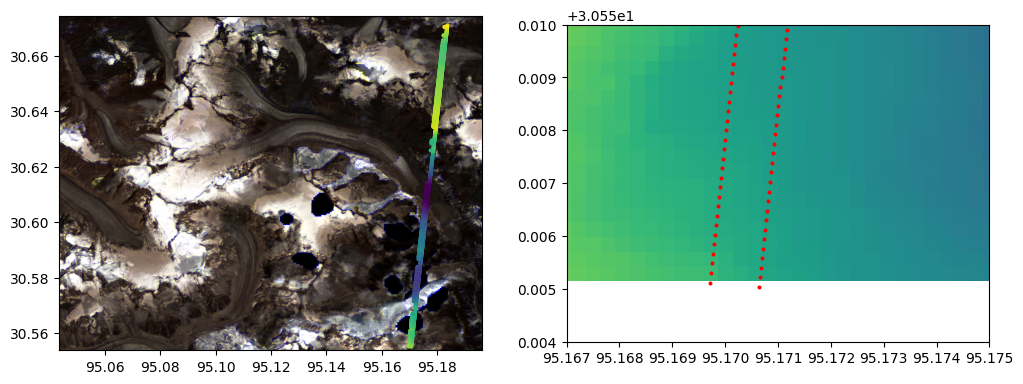

In [11]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))
imgShow(rsimg.array, extent=rsimg.geoextent, per_band_clip=10, ax=ax[0])
ax[0].scatter(x=vars_atl06['lon'], y=vars_atl06['lat'], c=vars_atl06['elev'], s=3.5)
imgShow(dem.array, extent=dem.geoextent, ax=ax[1])
ax[1].scatter(x=vars_atl06['lon'], y=vars_atl06['lat'], c='red', s=3.5)
# gla_vec.plot(ax=ax[0], facecolor="none", edgecolor='red')
# gla_vec.plot(ax=ax[1], facecolor="none", edgecolor='red')
ax[1].set_ylim(30.554,30.56)
ax[1].set_xlim(95.167, 95.175)


In [ ]:
# ## 筛选出冰川点
# ids_gla = np.zeros(shape=(vars_atl06['lon'].shape))
# for i, lon in enumerate(vars_atl06['lon']):
#     point = Point(lon, vars_atl06['lat'][i])
#     if gla_vec.geometry[0].contains(point):
#         ids_gla[i]=1
# ids_gla



In [35]:
def geo2imagexy(x, y, gdal_trans, rsimg_array, integer=True):
    '''
    des: from georeferenced location (i.e., lon, lat) to image location(col,row).
    note: the coordinate system should be same between x/y and gdal_trans.
    input:
        gdal_trans: obtained by gdal.Open() and .GetGeoTransform(), or by geotif_io.readTiff()['geotrans']
        x: project or georeferenced x, i.e.,lon
        y: project or georeferenced y, i.e., lat
        rsimg_array: np.array(), remote sensing image array, shape = (row, col)/(row, col, bands)
    return:
        image col and row corresponding to the georeferenced location.
    '''
    a = np.array([[gdal_trans[1], gdal_trans[2]], [gdal_trans[4], gdal_trans[5]]])
    b = np.array([x - gdal_trans[0], y - gdal_trans[3]])
    col_img, row_img = np.linalg.solve(a, b)
    if integer:
        row_img, col_img = np.floor(row_img).astype('int'), np.floor(col_img).astype('int')
    ## Mask out the points outside the image.
    ids_out = np.where((row_img>=rsimg_array.shape[0]) | (col_img>=rsimg_array.shape[1]))[0]
    print(ids_out)
    while len(ids_out) > 0:
        raise IndexError('The x and y out of image range')
    # row_img, col_img = row_img[ids], col_img[ids]
    return row_img, col_img




In [36]:
row, col = geo2imagexy(x=vars_atl06['lon'],
                         y=vars_atl06['lat'],
                         gdal_trans=dem.geotrans,
                         rsimg_array = dem.array,
                         integer=True)
dem_isat_fp = dem.array[row, col]
dem_isat_fp[90:100]


[ 614 1035]


IndexError: The x and y out of image range

In [1]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
### glacier region
ax[0].scatter(x=vars_atl06['lon'][ids_gla==1], y=vars_atl06['elev'][ids_gla==1], c='red', s=3.5)  ## icesat data
ax[0].scatter(x=vars_atl06['lon'][ids_gla==1], y=dem_isat_fp[ids_gla==1], c='green', s=3.5)  ## srtm data
ax[0].set_xlim(min(vars_atl06['lon']), max(vars_atl06['lon']))
ax[0].set_title('measurements on glacier region')
### non-glacier region
ax[1].scatter(x=vars_atl06['lon'][ids_gla==0], y=vars_atl06['elev'][ids_gla==0], c='red', s=3.5)  ## icesat data
ax[1].scatter(x=vars_atl06['lon'][ids_gla==0], y=dem_isat_fp[ids_gla==0], c='green', s=3.5)  ## srtm data
ax[1].set_xlim(min(vars_atl06['lon']), max(vars_atl06['lon']))
ax[1].set_title('measurements on non-glacier region')


NameError: name 'plt' is not defined

冰川高程变化计算

In [ ]:
## 冰川区域icesat-2观测值与dem高程值间差值
dif_ele = vars_atl06['elev'] - dem_isat_fp
ids_gla_thre = np.where((ids_gla==1) & (abs(dif_ele)<150))   ## glacier region and elevation change < 150
dif_ele_gla = dif_ele[ids_gla_thre]
print(dif_ele_gla.mean())
## 非冰川区域icesat-2观测值与dem高程值间差值
ids_stable_thre = np.where((ids_gla==0) & (abs(dif_ele)<50)) ## non-glacier region and elevation change < 50
dif_ele_stable = dif_ele[ids_stable_thre]
print(dif_ele_stable.mean())


-13.536416397822064
-3.38964902325006


In [ ]:
## 冰川高程变化改正
dif_ele_gla_cor = dif_ele_gla.mean()-dif_ele_stable.mean()
dif_ele_gla_cor


-10.146767374572004

In [ ]:
gla_ele_change_rate = dif_ele_gla_cor/(vars_atl06['time_dyr'][0]-2000) ## srtm：2000.2.11
print(gla_ele_change_rate)


-0.4926617462155448


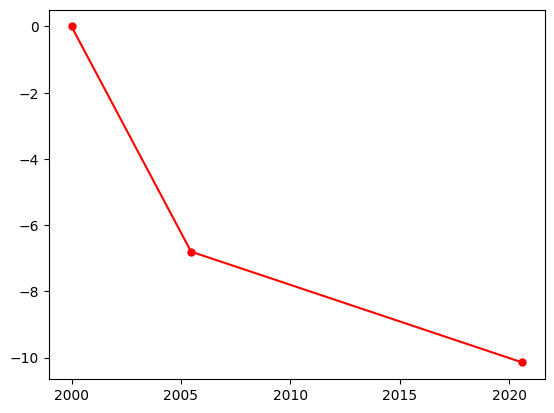

In [ ]:
time = [2000, 2005.46, vars_atl06['time_dyr'][0]]
ele_dif = [0, -6.799, dif_ele_gla_cor]
plt.plot(time, ele_dif, '.-r', markersize=10)


In [ ]:
sigma = np.std(dif_ele_gla)
print(sigma)


35.63337044937821


In [ ]:
ele_gla_isat2 = vars_atl06['elev'][ids_gla_thre]


In [ ]:
ele_bin_1 = [4000, 4500]
ele_bin_2 = [5000, 5500]
## bin_1
ids_ele_bin_1 = np.where((ele_gla_isat2>ele_bin_1[0]) \
                & (ele_gla_isat2<ele_bin_1[1]))
dif_ele_gla_bin1 = dif_ele_gla[ids_ele_bin_1]
mean_dif_ele_bin1 = dif_ele_gla_bin1.mean()
print(mean_dif_ele_bin1)


-33.60923200334821


In [ ]:
## bin_2
ids_ele_bin_2 = np.where((ele_gla_isat2>ele_bin_2[0]) \
                & (ele_gla_isat2<ele_bin_2[1]))
dif_ele_gla_bin2 = dif_ele_gla[ids_ele_bin_2]
mean_dif_ele_bin2 = dif_ele_gla_bin2.mean()
print(mean_dif_ele_bin2)


0.8290919126729249
